# $\mathrm{CosmoFlow}$ Starting Guide

Welcome to CosmoFlow!

This notebook aims to describe the basic functionalities of the routine <u> CosmoFlow </u> with some simple examples. More detailed information about the method and their use can be found in the paper:

[Cosmological Flow of Primordial Correlators (Werth, Pinol, Renaux-Petel 2023)](https://inspirehep.net/literature/2628782)

[The Cosmological Flow: a Systematic Approach to Inflationary Correlators (Pinol, Renaux-Petel, Werth 2023)](https://inspirehep.net/literature/2734774)

<div class="alert alert-block alert-info"><b>Disclaimer: </b> Please reach out to the developers if you have questions! Your questions and feedback are very valuable to us. </div>

In [1]:
# Importing the standard Python packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import time

# Importing the CosmoFlow modules, they must be located in the same parent folder as the tutorial notebook

from background_inputs import background_inputs
from model import model
from solver import solver

## Getting Started with a Scale-invariant Example

The modules are already implemented for the following theory at the level of the inflationary fluctuations

\begin{equation}
\begin{aligned}
    \mathcal{L}/a^3 = &-\frac{1}{2}\left[-\dot{\pi}_c^2 + c_s^2 \frac{(\partial_i \pi_c)^2}{a^2}\right] - \frac{1}{2}\left[ (\partial_\mu \sigma)^2 + m^2\sigma^2\right] + \rho \dot{\pi}_c\sigma \\
    & -\lambda_1\dot{\pi}_c\frac{(\partial_i \pi_c)^2}{a^2} - \lambda_2 \dot{\pi}_c^3
    -\mu\sigma^3 - \frac{1}{2}\alpha\dot{\pi}_c \sigma^2 - \frac{\kappa_1}{2} \frac{(\partial_i \pi_c)^2}{a^2}\sigma - \frac{\kappa_2}{2}\dot{\pi}_c^2\sigma\,,
\end{aligned}
\end{equation}
where $\pi_c$ is the canonically normalised Goldstone boson of broken time diffeomorphism invariance. It is related to the curvature perturbation through $\zeta = -Hc_s^{3/2}f_\pi^{-2}\pi_c$ with $f_\pi^4 \equiv 2M_{\text{pl}}^2|\dot{H}|c_s$. The field $\sigma$ is a massive scalar field. Note that some coupling constants are dimensionfull. For simplicity, we assume these couplings constant but they can in general depend on time.

### Theory Implementation

* When defining the couplings of the theory, one can allow for any time dependence. In this case, they are assumed constant for simplicity. All the couplings should therefore be defined as arrays. The module <u> background_inputs </u> will automatically create continuous functions out of the given time dependences.

* The couplings are all defined so that they are turned on adiabatically during the subhorizon evolution of the various modes. Hence the presence of <u> tanh </u>.

In [2]:
#Function that turns on interactions adiabatically (numerical i\epsilon prescription) 
def adiabatic(N_load, DeltaN):
    return (np.tanh((N_load + DeltaN - 1)/0.1) + 1)/2

In [3]:
n_back = 10000 # number of points for the background
N_load = np.linspace(-10, 20, n_back) # time span in efolds (N=0 should be located around horizon crossing of one mode)
H_load = np.ones(n_back) # Hubble scale set to unity

DeltaN = 5 # number of efolds before horizon crossing

# Quadratic theory

cs_load   = 1*np.ones(n_back)
m_load    = 3*np.ones(n_back)
rho_load  = 0.1*np.ones(n_back) * adiabatic(N_load, DeltaN)


# Cubic theory

lambda1_load = 0*np.ones(n_back) * adiabatic(N_load, DeltaN)
lambda2_load = 0*np.ones(n_back) * adiabatic(N_load, DeltaN)
mu_load      = 0*np.ones(n_back) * adiabatic(N_load, DeltaN)
alpha_load   = 0*np.ones(n_back) * adiabatic(N_load, DeltaN)
kappa1_load  = 1*np.ones(n_back) * adiabatic(N_load, DeltaN)
kappa2_load  = 0*np.ones(n_back) * adiabatic(N_load, DeltaN)


# Loading the background/coupling inputs and constructing continuous functions

background = background_inputs(N_load, H_load, cs_load, m_load, rho_load, lambda1_load, lambda2_load, mu_load, alpha_load, kappa1_load, kappa2_load)
interpolated = background.output()

### Numerical Parameters

In [4]:
Nspan = np.linspace(-10, 20, 500) # time span in efolds for the numerical integration
Nfield = 2 # number of fields
Rtol, Atol = [1e-4, 1e-4, 1e-4], [1e-180, 1e-180, 1e-180] # relative and absolute tolerance of the integrator
N_exit = 0 # horizon exit for a mode
Ni, Nf = N_exit - DeltaN, 20 # sets initial and final efolds for flow equation integration
N = np.linspace(Ni, Nf, 1000)

* The first element of Rtol/Atol corresponds to the precision for the real part of the power spectrum
* The second element of Rtol/Atol corresponds to the precision for the imaginary part of the power spectrum
* The third element of Rtol/Atol corresponds to the precision for both the power spectra and the bispectra

In [5]:
# Initialising the integrator with the theory and the numerical parameters

mdl = model(N = Nspan, Nfield = Nfield, interpolated = interpolated)

### Equilateral Momentum Configuration

In [6]:
kt = mdl.k_mode(N_exit) # gives the corresponding mode
k1, k2, k3 = kt, kt, kt # momentum configuration for the bispectrum (here equilateral)

In [7]:
# Integrating the flow equations

s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:112: RuntimeWarning: invalid value encountered in double_scalars
  d2 = norm((f1 - f0) / scale) / h0


All correlators are stored in _f[a][b, c, d]_ where

* the index _a_ equals 0, 1, 2 for the real part of the two-point correlators of the modes $k_1, k_2, k_3$
* the index _a_ equals 3, 4, 5 for the imaginary part of the two-point correlators of the modes $k_1, k_2, k_3$
* the index _a_ equals 6 for the three-point correlators
* the index _b_ equals 0, 1, 2, 3 for $\pi_c, \sigma, p_{\pi_c}, p_\sigma$
* the index _c_ equals 0, 1, 2, 3 for $\pi_c, \sigma, p_{\pi_c}, p_\sigma$
* the index _d_ equals 0, 1, 2, 3 for $\pi_c, \sigma, p_{\pi_c}, p_\sigma$ (only for _a_=6)

In [8]:
# Extracting all the correlators

f1_f1__k1 = f[0][0, 0] # field-field correlator of pi of mode k1
f1_f1__k2 = f[1][0, 0] # field-field correlator of pi of mode k2
f1_f1__k3 = f[2][0, 0] # field-field correlator of pi of mode k3

f2_f2__k1 = f[0][1, 1] # field-field correlator of sigma of mode k1
f2_f2__k2 = f[1][1, 1] # field-field correlator of sigma of mode k2
f2_f2__k3 = f[2][1, 1] # field-field correlator of sigma of mode k3

f1_f2__k1 = f[0][0, 1] # cross field-field correlator of pi and sigma
f1_p1__k1 = f[0][0, 2] # cross field-momentum correlator of pi and its conjugate momentum
f2_p2__k1 = f[0][1, 3] # cross field-momentum correlator of sigma and its conjugate momentum

f1_f1_f1 = f[6][0, 0, 0] # field-field-field correlator of pi
f1_f1_f2 = f[6][0, 0, 1] # field-field-field correlator of pi and one sigma
f1_f2_f2 = f[6][0, 1, 1] # field-field-field correlator of sigma and one pi
f2_f2_f2 = f[6][1, 1, 1] # field-field-field correlator of sigma

S = 1/(2*np.pi)**4/((f1_f1__k1[-1]*k1**3/2/np.pi**2 + f1_f1__k2[-1]*k2**3/2/np.pi**2 + f1_f1__k3[-1]*k3**3/2/np.pi**2)/3)**2 * (k1*k2*k3)**2 * f1_f1_f1 # shape function

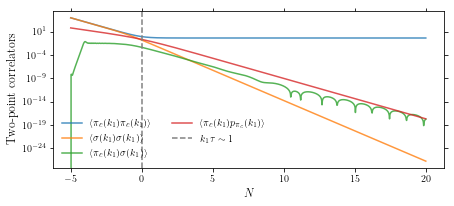

In [9]:
# Plotting the time evolution of two-point correlators

fig = plt.figure(figsize = (7, 3))
fig.subplots_adjust(bottom = 0.15)
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(bottom = "on", top = "on", left = "on", right = "on")
ax.tick_params(axis = 'both', labelsize = 10)

ax.semilogy(N, np.absolute(f1_f1__k1), label = "$\langle \pi_c(k_1) \pi_c(k_1)\\rangle$", color = "C0", alpha = 0.8)
ax.semilogy(N, np.absolute(f2_f2__k1), label = "$\langle \sigma(k_1) \sigma(k_1)\\rangle$", color = "C1", alpha = 0.8)
ax.semilogy(N, np.absolute(f1_f2__k1), label = "$\langle \pi_c(k_1) \sigma(k_1)\\rangle$", color = "C2", alpha = 0.8)
ax.semilogy(N, np.absolute(f1_p1__k1), label = "$\langle \pi_c(k_1) p_{\pi_c}(k_1)\\rangle$", color = "C3", alpha = 0.8)

ax.axvline(x = N_exit, ls = "--", color = "gray", label = "$k_1\\tau\sim 1$")
ax.set_xlabel("$N$", fontsize = 12)
ax.set_ylabel("Two-point correlators", fontsize = 12)
ax.legend(frameon = False, ncol = 2)




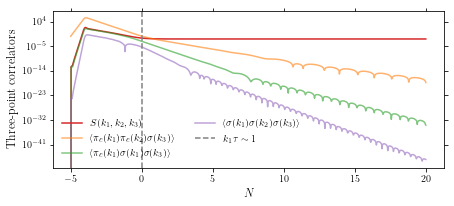

In [10]:
# Plotting the time evolution of three-point correlators

fig = plt.figure(figsize = (7, 3))
fig.subplots_adjust(bottom = 0.15)
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(bottom = "on", top = "on", left = "on", right = "on")
ax.tick_params(axis = 'both', labelsize = 10)

ax.semilogy(N, np.absolute(S), label = "$S(k_1, k_2, k_3)$", color = "C3", alpha = 1)

ax.semilogy(N, np.absolute(f1_f1_f2), label = "$\langle \pi_c(k_1) \pi_c(k_2) \sigma(k_3)\\rangle$", color = "C1", alpha = 0.6)
ax.semilogy(N, np.absolute(f1_f2_f2), label = "$\langle \pi_c(k_1) \sigma(k_1) \sigma(k_3)\\rangle$", color = "C2", alpha = 0.6)
ax.semilogy(N, np.absolute(f2_f2_f2), label = "$\langle \sigma(k_1) \sigma(k_2) \sigma(k_3)\\rangle$", color = "C4", alpha = 0.6)

ax.axvline(x = N_exit, ls = "--", color = "gray", label = "$k_1\\tau\sim 1$")
ax.set_xlabel("$N$", fontsize = 12)
ax.set_ylabel("Three-point correlators", fontsize = 12)
ax.legend(frameon = False, ncol = 2)


Only the correlators of $\pi_c$ remain constant on super-horizon scales, and hence survive until the end of inflation. Correlators of massive degrees of freedom (or conjugate momenta) start to decay while oscillating when they cross the horizon.

### Squeezed Momentum Configuration


In [11]:
kappa = 1e-1 # squeezing parameter
kt = mdl.k_mode(N_exit) # gives the corresponding mode
k1, k2, k3 = kt/kappa, kt/kappa, kt # momentum configuration for the bispectrum

In [12]:
# Integrating the flow equations

s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:112: RuntimeWarning: invalid value encountered in double_scalars
  d2 = norm((f1 - f0) / scale) / h0


The numerical integration can take a few seconds because the integration of the subhorizon time evolution of correlators is computationally expensive.

In [13]:
# Extracting all the correlators

f1_f1__k1 = f[0][0, 0] # field-field correlator of pi of mode k1
f1_f1__k2 = f[1][0, 0] # field-field correlator of pi of mode k2
f1_f1__k3 = f[2][0, 0] # field-field correlator of pi of mode k3

f1_f1_f1 = f[6][0, 0, 0] # field-field-field correlator of pi

S = 1/(2*np.pi)**4/((f1_f1__k1[-1]*k1**3/2/np.pi**2 + f1_f1__k2[-1]*k2**3/2/np.pi**2 + f1_f1__k3[-1]*k3**3/2/np.pi**2)/3)**2 * (k1*k2*k3)**2 * f1_f1_f1 # shape function

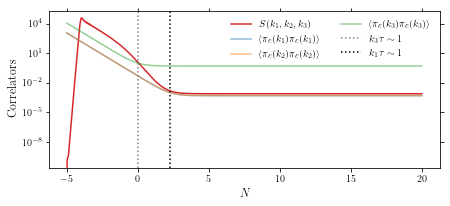

In [14]:
# Plotting the time evolution of correlators

fig = plt.figure(figsize = (7, 3))
fig.subplots_adjust(bottom = 0.15)
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(bottom = "on", top = "on", left = "on", right = "on")
ax.tick_params(axis = 'both', labelsize = 10)

ax.semilogy(N, np.absolute(S), label = "$S(k_1, k_2, k_3)$", color = "C3", ls = "-")

ax.semilogy(N, np.absolute(f1_f1__k1), label = "$\langle \pi_c(k_1) \pi_c(k_1) \\rangle$", color = "C0", alpha = 0.5, ls = "-")
ax.semilogy(N, np.absolute(f1_f1__k2), label = "$\langle \pi_c(k_2) \pi_c(k_2) \\rangle$", color = "C1", alpha = 0.5, ls = "-")
ax.semilogy(N, np.absolute(f1_f1__k3), label = "$\langle \pi_c(k_3) \pi_c(k_3) \\rangle$", color = "C2", alpha = 0.5, ls = "-")

ax.axvline(x = N_exit, ls = "dotted", color = "gray", label = "$k_3\\tau\sim 1$")
ax.axvline(x = -np.log(kappa), ls = "dotted", color = "k", label = "$k_1\\tau\sim 1$")
ax.set_xlabel("$N$", fontsize = 12)
ax.set_ylabel("Correlators", fontsize = 12)
ax.legend(frameon = False, ncol = 2)


The modes $k_3$ exit the horizon before the modes $k_1$ and $k_2$.

# Time-dependent Couplings

We provide the reader with an example where the quadratic coupling has some non-trivial time dependence of the form

\begin{equation}
    \rho(t) = \rho_0 \left(a/a_0\right)^{-3/2} \sin[\omega_c(t-t_0)] \times \frac{1}{2}\left[1+\tanh\left(\frac{t-t_0}{\Delta t}\right)\right] \,.
\end{equation}
We only compute the power spectrum but not the bispectrum, although its shape and scale dependence can be easily computed too.

<div class="alert alert-block alert-warning"><b>Warning: </b> Computing the power spectrum or the bispectrum for several momentum configurations i.e. doing multiple integration of the flow equations is computationally very expensive. The following cells might take a minute to run. </div>

In [15]:
# Importing tqdm for integration step visualisation

from tqdm import tqdm 

In [16]:
n_back = 10000 # number of points for the background
N_load = np.linspace(-20, 20, n_back) # time span in efolds (N=0 should be located around horizon crossing of one mode)
H_load = np.ones(n_back) # Hubble scale set to unity


# Quadratic theory

cs_load   = 1*np.ones(n_back)
m_load    = 3*np.ones(n_back)


# Feature at N=0
delta_rho0 = 20 # amplitude of the feature
n = 3/2 # decay of the feature
wc = 0.1 # frequency of the oscillatory feature
rho_load = delta_rho0 * np.exp(-n*N_load) * np.sin(wc*N_load) * (np.tanh((N_load)/0.1) + 1)/2


# Cubic theory

lambda1_load = 1*np.ones(n_back) * (np.tanh((N_load + 4)/0.1) + 1)/2
lambda2_load = 0*np.ones(n_back) * (np.tanh((N_load + 4)/0.1) + 1)/2
mu_load      = 0*np.ones(n_back) * (np.tanh((N_load + 4)/0.1) + 1)/2
alpha_load   = 0*np.ones(n_back) * (np.tanh((N_load + 4)/0.1) + 1)/2
kappa1_load  = 0*np.ones(n_back) * (np.tanh((N_load + 4)/0.1) + 1)/2
kappa2_load  = 0*np.ones(n_back) * (np.tanh((N_load + 4)/0.1) + 1)/2


# Loading the background/coupling inputs and constructing continuous functions

background = background_inputs(N_load, H_load, cs_load, m_load, rho_load, lambda1_load, lambda2_load, mu_load, alpha_load, kappa1_load, kappa2_load)
interpolated = background.output()

In [17]:
kfeature = 1 # the corresponding k of the feature
n_points = 100
N_efolds = np.linspace(-3, 3, n_points)

k = np.zeros(n_points) # k span
P = np.zeros(n_points) # dimensionless power spectrum.

for i in tqdm(range(n_points)):
    N_exit = N_efolds[i]
    DeltaN = 3.5 # number of efolds before horizon crossing

    #background = background_inputs(N_load, H_load, cs_load, m_load, rho_load, lambda1_load, lambda2_load, mu_load, alpha_load, kappa1_load, kappa2_load)
    #interpolated = background.output()

    Nspan = np.linspace(-20, 20, 1000)
    Nfield = 2
    Rtol, Atol = [1e-4, 1e-4, 1e-4], [1e-180, 1e-180, 1e-180]
    mdl = model(N = Nspan, Nfield = Nfield, interpolated = interpolated)

    kt = mdl.k_mode(N_exit)
    Ni, Nf = N_exit - DeltaN, 20 # sets initial and final efolds for flow equation integration
    N = np.linspace(Ni, Nf, 1000)
    
    try:
        s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
        SigmaAB = s.SigmaAB_solution(k = kt, part = "Re")
        k[i] = kt
        P[i] = SigmaAB[0, 0][-1] * kt**3/2/np.pi**2
    except:
        k[i] = kt
        P[i] = 0

 75%|███████████████████████████████▌          | 75/100 [02:31<00:22,  1.10it/s]/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:112: RuntimeWarning: invalid value encountered in double_scalars
  d2 = norm((f1 - f0) / scale) / h0
100%|█████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


Text(0, 0.5, 'Power Spectrum')

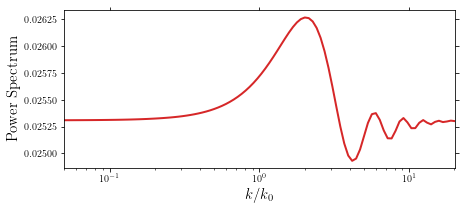

In [18]:
# Plotting the dimensionless power spectrum

fig = plt.figure(figsize = (7, 3))
fig.subplots_adjust(bottom = 0.15)
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(bottom = "on", top = "on", left = "on", right = "on")
ax.tick_params(axis = 'both', labelsize = 10)

ax.semilogx(k, P, ls = "-", alpha = 1, color = "C3", linewidth = 2)
ax.set_xlim(np.min(k), np.max(k))
ax.set_xlabel("$k/k_0$", fontsize = 15)
ax.set_ylabel("Power Spectrum", fontsize = 15)